In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [38]:
connection = psycopg2.connect(host='', dbname='investing', user='testid', password='', port=5432)
cursor = connection.cursor()

<div class="alert alert-success">
    <h3>1-1. Data (SQL)</h3>
</div>

In [39]:
sql = """
    SELECT *
    FROM coin_candles
"""
cursor.execute(sql)
df = pd.DataFrame(cursor.fetchall(), columns = ['market', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'value'])
df.set_index('datetime', inplace=True)
df.sort_index(ascending=True)
df.to_csv('data.csv')

<div class="alert alert-success">
    <h3>1-2. Data (File)</h3>
</div>

In [3]:
df = pd.read_csv('./data.csv', header=0)
df.set_index('datetime', inplace=True)
df.sort_index(ascending=True, inplace=True)

<div class="alert alert-success">
    <h3>2. 기술적 지표 (Feature Engineering)</h3>
</div>

In [4]:
def get_stochastic_fast_k(close_price, low, high, n=5):
    fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return fast_k

# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
    slow_k = fast_k.rolling(n).mean()
    return slow_k

# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
    slow_d = slow_k.rolling(n).mean()
    return slow_d

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def get_rsi(price, period=14):
    delta = price.diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    
    _gain = gains.ewm(com=(period-1), min_periods=period).mean()
    _loss = declines.abs().ewm(com=(period-1), min_periods=period).mean()
    RS = _gain / _loss
    
    return pd.Series(100 - (100/(1+RS)), name = 'RSI')


## MA: 이동평균선
df['MA5'] = df['close'].rolling(window=5).mean()
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA60'] = df['close'].rolling(window=60).mean()
df['MA120'] = df['close'].rolling(window=120).mean()
df['MA200'] = df['close'].rolling(window=200).mean()


## 볼린저 밴드
df['stddev'] = df['close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['MA20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['MA20'] - 2*df['stddev'] # 하단밴드
df['upper-lower'] = df['upper']-df['lower']

df['MA20-MA5'] = df['MA20'] - df['MA5']
df['MA60-MA20'] = df['MA60'] - df['MA20']
df['MA120-MA60'] = df['MA120'] - df['MA60']
df['MA200-MA120'] = df['MA200'] - df['MA120']


## VA: 평균 거래량 (120일기준)
df['VA'] = df['volume'].rolling(window=120).mean()
df['V/VA'] = df['volume']/df['VA']


# MACD
macd_short, macd_long, macd_signal=12,26,9 #기본값
df["MACD_short"]=df['close'].ewm(span=macd_short).mean()
df["MACD_long"]=df['close'].ewm(span=macd_long).mean()
df["MACD"]=df.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
df["MACD_signal"]=df["MACD"].ewm(span=macd_signal).mean()  
df["MACD_oscillator"]=df.apply(lambda x:(x["MACD"]-x["MACD_signal"]), axis=1)
df["MACD_sign"]=df.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)


# fast_k, slow_k, slow_d를 획득
df['fast_k5'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 5)
df['slow_k3'] = get_stochastic_slow_k(df['fast_k5'], 3)
df['slow_d3'] = get_stochastic_slow_d(df['slow_k3'], 3)

df['fast_k10'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 10)
df['slow_k6'] = get_stochastic_slow_k(df['fast_k10'], 6)
df['slow_d6'] = get_stochastic_slow_d(df['slow_k6'], 6)

df['fast_k20'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 20)
df['slow_k12'] = get_stochastic_slow_k(df['fast_k20'], 12)
df['slow_d12'] = get_stochastic_slow_d(df['slow_k12'], 12)


# RSI
df['rsi'] = get_rsi(df['close'])

In [5]:
df.head()

,market,open,high,low,close,volume,value,MA5,MA20,MA60,...,fast_k5,slow_k3,slow_d3,fast_k10,slow_k6,slow_d6,fast_k20,slow_k12,slow_d12,rsi
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-05 21:31:00,KRW-ETH,4130000.0,4133000.0,4128000.0,4128000.0,191.443844,7.908853e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-05 21:32:00,KRW-ETH,4128000.0,4130000.0,4125000.0,4127000.0,76.999984,3.177948e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-05 21:33:00,KRW-ETH,4127000.0,4127000.0,4125000.0,4127000.0,70.118890,2.893039e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-05 21:34:00,KRW-ETH,4126000.0,4133000.0,4125000.0,4131000.0,131.506238,5.427488e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-05 21:35:00,KRW-ETH,4131000.0,4136000.0,4130000.0,4133000.0,77.488885,3.202347e+08,4129200.0,NaN,NaN,...,72.727273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-success">
    <h3>3-1. Independent Variable 설정</h3>
</div>

In [6]:
#t-1의 값을 Feature로 사용하기 위함
features = [
    'close', 'open', 'high', 'low', 'volume', 'MA5', 'MA20', 'MA60', 'MA120', 'MA200',
    'MA200-MA120', 'MA120-MA60', 'MA60-MA20', 'MA20-MA5', 'VA', 'V/VA', 'MACD', 'MACD_oscillator', 
    'MACD_signal', 'fast_k5', 'slow_k3', 'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 
    'fast_k20', 'slow_k12', 'slow_d12', 'rsi', 'upper', 'lower', 'stddev', 'upper-lower'
]

for feature in features:
    df[feature+'-1']=df[feature].shift(1)
    

#사용 Feature
selected_features = [
    'volume-1', 'VA-1', 'V/VA-1',
    'MA20-MA5-1', 'MA60-MA20-1', 'MA120-MA60-1', 'MA200-MA120-1',
    'MACD-1', 'MACD_oscillator-1', 'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'upper-1', 'lower-1', 'stddev-1', 'upper-lower-1'
]

X = df[selected_features].copy()
X.dropna(inplace=True)

<div class="alert alert-success">
    <h3>3-2. Dependent Variable 설정</h3>
</div>

In [36]:
target_th = 0.02 # target earning rate per trade
fee = 0.0005 # trade fee
max_window = 120 # minutes

In [8]:
y1 = df[["close"]].copy()
y1["close_t+20"] = y1["close"].shift(-20)
y1["close_t+60"] = y1["close"].shift(-60)
y1["close_t+120"] = y1["close"].shift(-120)

y1['earn+20'] = ((1 + target_th) * y1['close'] < y1['close_t+20']).astype(int)
y1['earn+60'] = ((1 + target_th) * y1['close'] < y1['close_t+60']).astype(int)
y1['earn+120'] = ((1 + target_th) * y1['close'] < y1['close_t+120']).astype(int)

y1["target"] = y1["earn+120"]
y1.dropna(inplace=True)

In [71]:
# Option2 - Hit the target in max_window (=120)
y2 = df[["close"]].copy()
y2.sort_index(inplace=True, ascending=False)
y2["max_in_wind"] = y2.rolling(max_window, closed="left").max()
y2["max_earn_in_wind"] = y2["max_in_wind"] / y2["close"] - 1
y2["target"] = (y2["max_earn_in_wind"] >= target_th).astype(int)
y2.sort_index(inplace=True)
y2["close_t+{}".format(max_window)] = y2["close"].shift(-max_window)

# target 수익률을 넘어서는 시간 추가
def idxmax(s, w):
    i = 0
    while i + w < len(s):
        yield(s.iloc[i:i+w].idxmax())
        i += 1

y2['idxmax'] = pd.Series(idxmax(y2['close'], 120), y2.index[:-max_window])
y2.dropna(inplace=True)

In [10]:
# Option3 - Multi Classification 
y3 = df[["close"]].copy()

class_unit = 10 #minutes
for t in range(class_unit, max_window + class_unit, class_unit):
    y3["close_t+{}".format(t)] = y3["close"].shift(-t)
    y3["earn+{}".format(t)] = ((y3["close_t+{}".format(t)] / y3["close"] - 1) > target_th).astype(int)

selected_columns = ["earn+{}".format(t) for t in range(class_unit, max_window+class_unit, class_unit)]
target = y3[selected_columns].values.argmax(axis=1) + 1
target[y3[selected_columns].values.sum(axis=1) == 0] = 0
y3["target"] = target
y3.dropna(inplace=True)


<div class="alert alert-success">
    <h3>4. Train Model</h3>
</div>

In [11]:
#t-1의 값을 Feature로 사용하기 위함
data1 = X.join(y1[['target']], how='inner')
data2 = X.join(y2[['target']], how='inner')
data3 = X.join(y3[['target']], how='inner')

<AxesSubplot:xlabel='datetime'>

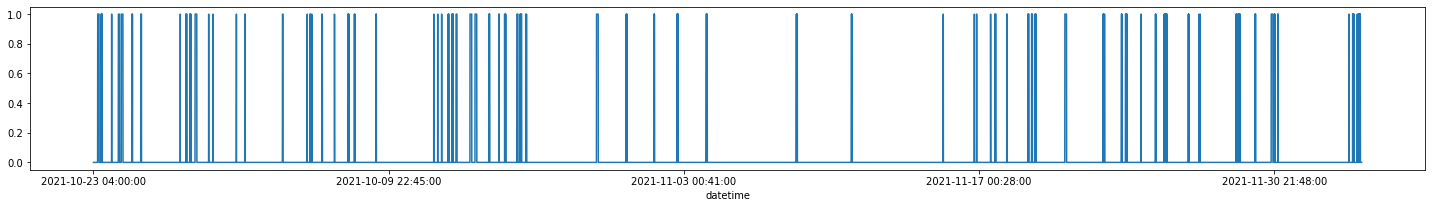

In [111]:
data1["target"].plot(figsize=(25, 3))

<AxesSubplot:xlabel='datetime'>

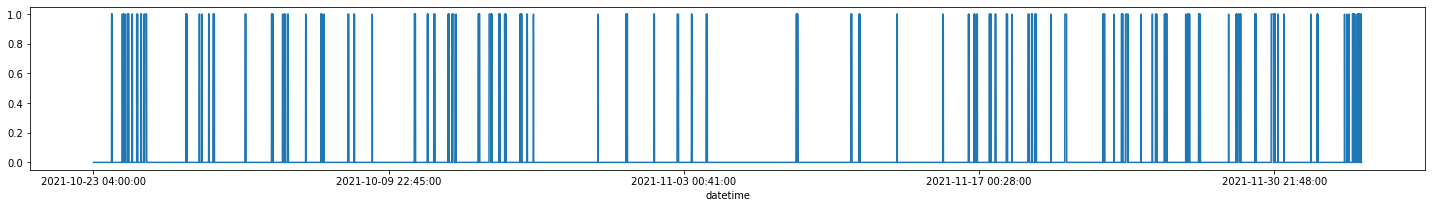

In [112]:
data2["target"].plot(figsize=(25, 3))

<AxesSubplot:xlabel='datetime'>

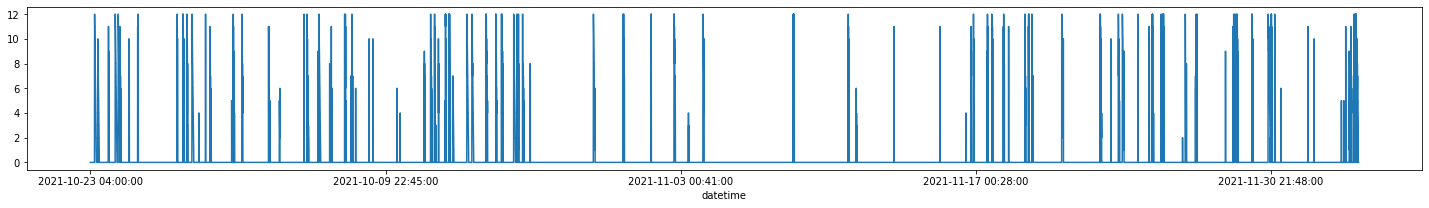

In [113]:
data3["target"].plot(figsize=(25, 3))

<div class="alert alert-warning">
    <h3>Option 1 (Fixed time)</h3>
</div>

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data1[selected_features], data1['target'], test_size=0.25, random_state=123456)

In [125]:
len(X_test.columns)

21

In [129]:
#시간으로 샘플링
start_date = "2021-11-01 00:00:00"
split_date = "2021-12-01 00:00:00"

data1_train = data1[start_date:split_date]
data1_train = data1_train.sample(frac=1)
data1_test = data1[split_date:]

In [116]:
rf1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf1.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [138]:

predicted = rf1.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf1.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.986
Mean accuracy score: 0.95


In [139]:
loss1 = df.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((loss1['close_t+120'] - loss1['close']).mean()))
print('min: {}'.format((loss1['close_t+120'] - loss1['close']).min()))
print('max: {}'.format((loss1['close_t+120'] - loss1['close']).max()))


avg: 263448.11320754717
min: 45000.0
max: 991000.0


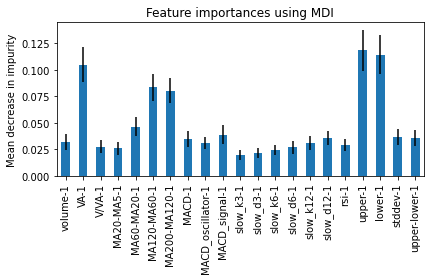

In [141]:
import numpy as np

importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class="alert alert-warning">
    <h3>Option 2 (Hit the target within window)</h3>
</div>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data2[selected_features], data2['target'], test_size=0.25, random_state=123456)

In [24]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf2.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [25]:
predicted = rf2.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.975
Mean accuracy score: 0.975


In [21]:
y2.head()

,close,max_in_wind,max_earn_in_wind,target,clost_t+120
datetime,,,,,
2021-10-05 21:31:00,4128000.0,4195000.0,0.016231,0,4150000.0
2021-10-05 21:32:00,4127000.0,4195000.0,0.016477,0,4137000.0
2021-10-05 21:33:00,4127000.0,4195000.0,0.016477,0,4139000.0
2021-10-05 21:34:00,4131000.0,4195000.0,0.015493,0,4140000.0
2021-10-05 21:35:00,4133000.0,4195000.0,0.015001,0,4140000.0


In [28]:
# 실패시 손실 계산
loss2 = y2.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).mean()))
print('min: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).min()))
print('max: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).max()))

avg: 58166.666666666664
min: -28000.0
max: 104000.0


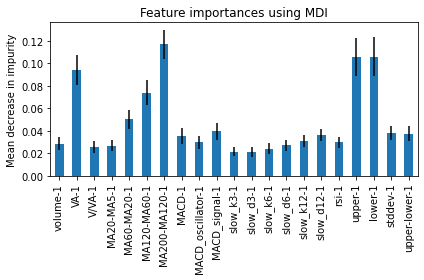

In [144]:
import numpy as np

importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class="alert alert-danger">
    <h3>Target 1인 상황에서 MDD (Maximum Draw Down) 계산</h3>
</div>

In [72]:
y2.head()

,close,max_in_wind,max_earn_in_wind,target,close_t+120,idxmax
datetime,,,,,,
2021-10-05 21:31:00,4128000.0,4195000.0,0.016231,0,4150000.0,2021-10-05 23:16:00
2021-10-05 21:32:00,4127000.0,4195000.0,0.016477,0,4137000.0,2021-10-05 23:16:00
2021-10-05 21:33:00,4127000.0,4195000.0,0.016477,0,4139000.0,2021-10-05 23:16:00
2021-10-05 21:34:00,4131000.0,4195000.0,0.015493,0,4140000.0,2021-10-05 23:16:00
2021-10-05 21:35:00,4133000.0,4195000.0,0.015001,0,4140000.0,2021-10-05 23:16:00


In [142]:
# target hit한 window내, 최대 낙폭 index와 금액 계산
def mdd(y):
    for idx, row in y.iterrows():
        yield y[idx:row['idxmax']]['close'].idxmin(), y[idx:row['idxmax']]['close'].min() - row['close']

MDD = pd.DataFrame(mdd(y2), index=y2.index, columns=['idxmin', 'mdd'])

In [106]:
y2_MDD = y2.join(MDD, how='inner')

In [107]:
y2_MDD.head()

,close,max_in_wind,max_earn_in_wind,target,close_t+120,idxmax,idxmin,mdd
datetime,,,,,,,,
2021-10-05 21:31:00,4128000.0,4195000.0,0.016231,0,4150000.0,2021-10-05 23:16:00,2021-10-05 22:11:00,-3000.0
2021-10-05 21:32:00,4127000.0,4195000.0,0.016477,0,4137000.0,2021-10-05 23:16:00,2021-10-05 22:11:00,-2000.0
2021-10-05 21:33:00,4127000.0,4195000.0,0.016477,0,4139000.0,2021-10-05 23:16:00,2021-10-05 22:11:00,-2000.0
2021-10-05 21:34:00,4131000.0,4195000.0,0.015493,0,4140000.0,2021-10-05 23:16:00,2021-10-05 22:11:00,-6000.0
2021-10-05 21:35:00,4133000.0,4195000.0,0.015001,0,4140000.0,2021-10-05 23:16:00,2021-10-05 22:11:00,-8000.0


In [129]:
# 낙폭 정도 Normal Test
from scipy.stats import normaltest

stat, p = normaltest(y2_MDD['mdd'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=137279.042, p=0.000
Sample does not look Gaussian (reject H0)


Total size: 4378
Worst MDD: -607000.0


<AxesSubplot:xlabel='datetime'>

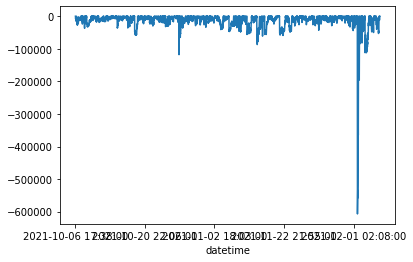

In [130]:
y2_target1 = y2_MDD[y2_MDD['target']==1]
print('Total size: {}'.format(len(y2_target1)))
print('Worst MDD: {}'.format(y2_target1['mdd'].min()))
y2_target1['mdd'].plot()

In [131]:
y2_target1['mdd_ratio'] = y2_target1['mdd']/y2_target1['close']
print('손해 비율 (mean): {}'.format(y2_target1['mdd_ratio'].mean()))
print('손해 비율 (std): {}'.format(y2_target1['mdd_ratio'].std()))
print('손해 비율 (min): {}'.format(y2_target1['mdd_ratio'].min()))

손해 비율 (mean): -0.0028874969864878973
손해 비율 (std): 0.006754362546615842
손해 비율 (min): -0.12120607028753994


<ipython-input-131-feaac8ef36b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y2_target1['mdd_ratio'] = y2_target1['mdd']/y2_target1['close']


In [140]:
# target threshold보다 더 많은 손해가 중간에 발생한 경우 

print('Target 1 규모: {}'.format(len(y2_target1)))
print('최대낙폭 target_th 이상: {}'.format(len(y2_target1[y2_target1['mdd_ratio']<=-target_th])))

Target 1 규모: 4378
최대낙폭 threshord_th 이상: 38


<div class="alert alert-info">
    <h4>%% 최대 낙폭을 줄이는 알고리즘을 추가하여 손실을 줄이는 방식으로</h4>
</div>

### - Grid Search 너무 느림

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [55]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()
